In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans, AgglomerativeClustering
from skimage.feature import peak_local_max
from skimage.segmentation import flood_fill, watershed
from scipy import ndimage

### load image:

In [2]:
path = "image.png"
bgr = cv2.imread(path)

### display each channel of opencv color spaces:

In [3]:
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

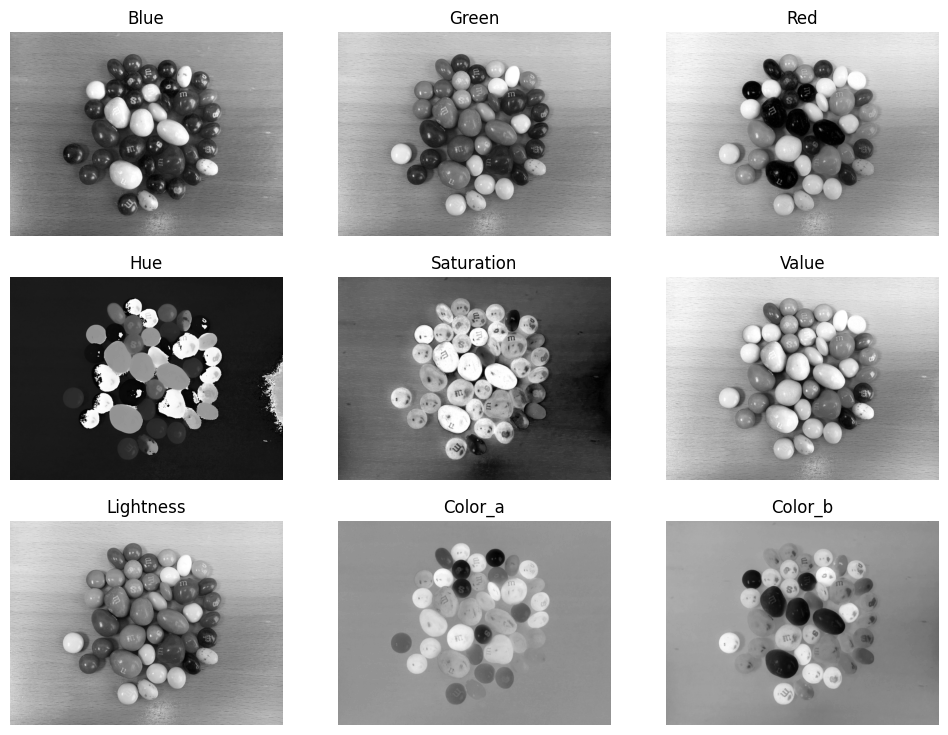

In [4]:
c_spaces = [bgr, hsv, lab]
titles = ["Blue", "Green", "Red", "Hue", "Saturation", "Value", "Lightness", "Color_a", "Color_b"]

fig, axs = plt.subplots(3, 3, figsize=(12, 9))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(c_spaces[i][:,:,j], cmap="gray")
        axs[i, j].axis('off')
        axs[i, j].title.set_text(titles[i*3+j])

### extract the foreground (beans):

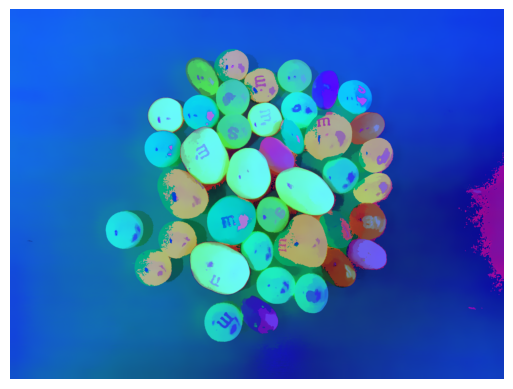

In [5]:
shifted = cv2.pyrMeanShiftFiltering(hsv, 25, 25)

# Using mean shift filtering to flatten color gradients: it showed better results than e.g. median filtering 
# but also has longer computation time. Therefore I try to keep the second argument, the spatial range, low.

plt.axis('off')
plt.imshow(shifted)

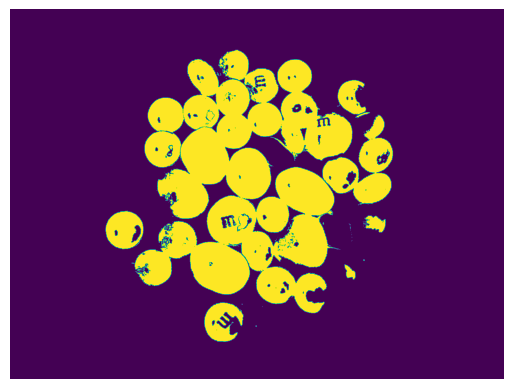

In [6]:
dim = 3
n_clusters = 2

array = np.ndarray((bgr.shape[0], bgr.shape[1], dim))
segmented = np.ndarray((bgr.shape[0], bgr.shape[1]))

array[:,:,:3] = shifted
        
array = array.reshape((bgr.shape[0] * bgr.shape[1], dim))
segmented = segmented.reshape((bgr.shape[0] * bgr.shape[1]))

kmeans = KMeans(n_init="auto", n_clusters=n_clusters, max_iter=200, tol=1e-3, random_state=5)
kmeans.fit(array)

# bg = np.argmin(kmeans.cluster_centers_.mean(axis=1))
for i, label in enumerate(kmeans.labels_):
    segmented[i] = label
    
# Using k-means clustering for the segmentation of the foreground: Adding more features as well as 
# normalization or scaling did not really help. In this step I am losing some beans but it works well
# for the shadow between the beans.

segmented = segmented.reshape((bgr.shape[0], bgr.shape[1])).astype("uint8")
plt.axis('off')
plt.imshow(segmented)

### extract light reflection (glare), add to foreground:

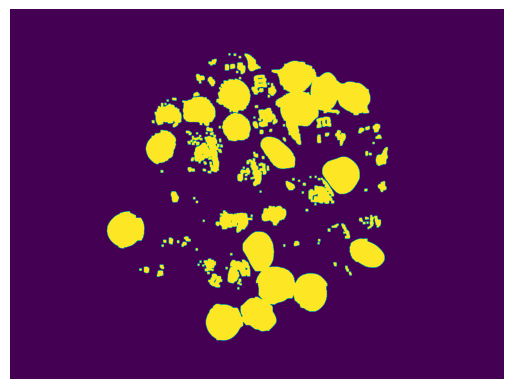

In [7]:
gray = lab[:,:,0]
_, thresh = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)

# Thresholding the first channel of LAB color space to get bright areas, which will also return bright areas
# of the background

blurred = cv2.medianBlur(bgr, 55)
edges = cv2.Canny(blurred, 10, 20)
kernel = np.ones((5,5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations = 1)
flooded = flood_fill(dilated, (0, 0), 100, tolerance=10)

bg = np.ndarray(flooded.shape)
bg = (flooded != 100).astype("uint8")
erode = cv2.erode(bg, kernel, iterations = 5)

# Estimating the outline of the foreground by getting its edges and using the flood-fill algorithm
# to fill the outer area, which can be then excluded from the light area to get the reflections of 
# the beans only. Reflection is here to be seen in a broad sense since I also get some whole beans.

substracted = (thresh & erode)
reflection = cv2.dilate(substracted, kernel, iterations = 2)
plt.axis('off')
plt.imshow(reflection)

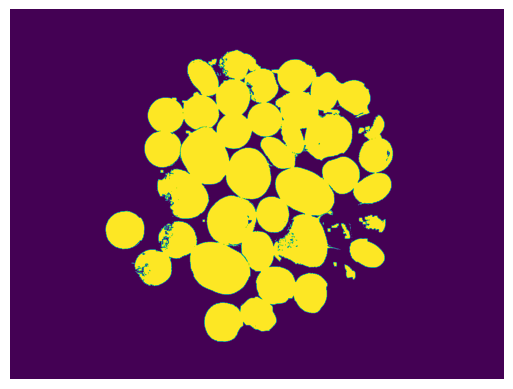

In [8]:
# Combining the segmented foreground and reflections

foreground = (segmented | reflection)
plt.axis('off')
plt.imshow(foreground)

### split connected areas, measure area and circumference of each segment:

found 39 segments


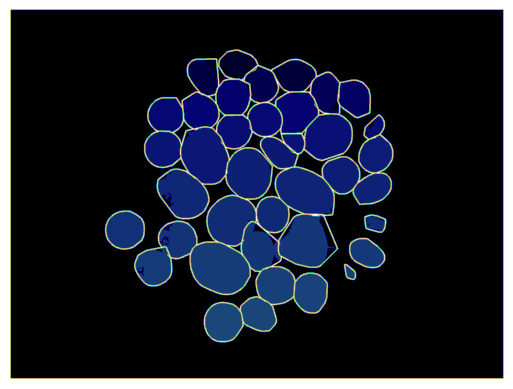

In [9]:
# Using the watershed algorithm to split the foreground into smaller segments:
# The segmentation is based on the distance to the closest background-pixel and works well for convex objects.
# At first, the distance for each pixel is calculated. Then local maxima are selected and passed to the
# watershed function as markers. After each segment is formed, its outline can be approximated.

draw = np.ndarray(foreground.shape)

distance = ndimage.distance_transform_edt(foreground)
peak_idx = peak_local_max(distance, min_distance=50, labels=foreground)
peak_mask = np.zeros_like(foreground, dtype=bool)
peak_mask[tuple(peak_idx.T)] = True
markers = ndimage.label(peak_mask)[0]

labels = watershed(-distance, markers, mask=foreground)
stats = np.ndarray((len(np.unique(labels)), 4))

print(f"found {(len(np.unique(labels)) - 1)} segments")

for n, label in enumerate(np.unique(labels)):
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours[0], key=cv2.contourArea)
    hull = cv2.convexHull(contour, returnPoints = True)
    area = cv2.contourArea(hull)
    length = cv2.arcLength(hull, True)
    stats[n,:] = area, area, area, area/length
    
    cv2.drawContours(draw, [contour], -1, n, -1)
    cv2.drawContours(draw, [hull], -1, (255,255,255), 3)
    
plt.axis('off')
plt.imshow(draw, cmap="gist_earth")

### classify segments

In [10]:
dim = 2
n_clusters = 4

X = stats[1:,:]

for i in range(dim):
    X[:,i] = np.abs((X[:,i] - X[:,i].mean()) / X[:,i].std())
# normalizing

clustering = KMeans(n_init="auto", n_clusters=n_clusters, max_iter=200, tol=1e-3, random_state=5).fit(X)
# clustering = AgglomerativeClustering(n_clusters=4).fit(X)

# Using k-means clustering to classify each segment into four clusters:
# There are many more features and clustering algorihtms to explore and to achieve better results.
# Possibly, the performance could be much better, when using a supervised learning algorithm.
# In general, I hand-picked many parameters during the process of segmentation and classification, 
# which is not ideal.

clustering.labels_

array([3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 2, 3, 1, 2, 0, 1, 3, 3, 3, 1, 3,
       1, 1, 3, 1, 2, 0, 0, 0, 1, 3, 0, 1, 2, 0, 0, 3, 0], dtype=int32)

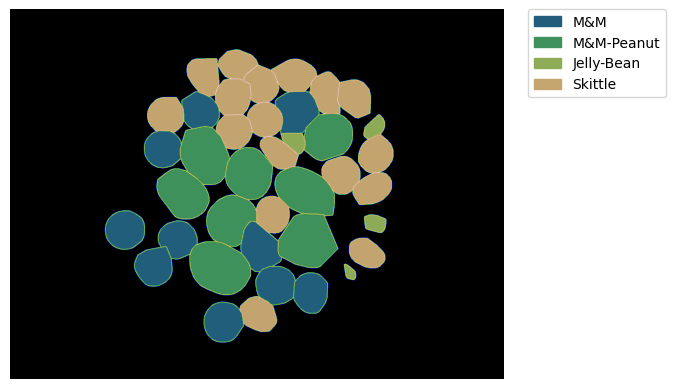

In [11]:
classes = ["M&M", "M&M-Peanut", "Jelly-Bean", "Skittle"]

res = np.ndarray(draw.shape)
for n, label in enumerate(np.unique(labels)):
    if n == 0:
        continue
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours[0], key=cv2.contourArea)
    hull = cv2.convexHull(contour, returnPoints = True)
    cv2.drawContours(res, [hull], -1, 10, 3)
    cv2.drawContours(res, [hull], -1, int(clustering.labels_[n-1])*2+2, -1)
    
fig = plt.imshow(res, cmap="gist_earth")
plt.axis('off')
values = np.unique(res.ravel())[1:-1]
colors = [fig.cmap(fig.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=classes[i] ) for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('result.png', bbox_inches='tight')

### metrics

In [ ]:
# There are a number of metrics that can be used to evaluate the performance of the clustering.

# Some of them are based on the variance of the clusters, which works in unsupervised learning:
# Sum of squares (WCSS), Sillouette score, Davies–Bouldin index and many more

# Some of them are based on the true labels, which works only in supervised learning:
# Accuracy, Precision, Recall, F1-score, Normalize mutual information, Adjusted rand index and many more

# There are semi-supervised approaches, in which you dont know each true label but
# the amount of samples in each cluster, e.g. 8 M&M-Peanuts etc.

# There can also be custom metrics to evaluate the performance of the segmentation.

# It would be nice to use grid-search to optimise some of the parameters during segmentation and clustering, 
# and therefore we need good metrics.